### Практическая работа №2 по дисциплине "Математическое моделирование в САПР"
Выполнена студентом группы БИВТ-18-3 ИТКН НИТУ "МИСиС" Ковешниковым Арсением
#### Построение дерева достижимости сети Петри

In [78]:
import math
import numpy as np
import pandas as pd
import xlrd
from IPython.display import Image

В данном примере используем сеть Петри с пары от 01.04.2021

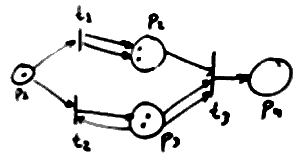

In [79]:
Image("img/petrinet.png")

Получим векторное описание сети Петри из .xlsx файла. Количество позиций определяется по количеству столбцов, переходов — по количеству входных/выходных векторов. Несовпадение количества входных/выходных векторов вызывает ошибку.

In [80]:
with open('petrinet2.xlsx', 'rb') as file:
    df = pd.read_excel(file, engine='openpyxl', index_col=0)
    if (df.loc['I'].shape[0] != df.loc['O'].shape[0]):
        raise SyntaxError("Неверное содержание файла!")
display(df)

,p1,p2,p3,p4
m,3,0,2,0
I,1,0,0,0
I,1,0,1,0
I,0,1,2,0
O,0,2,0,0
O,0,0,1,0
O,0,0,0,1


Выведем количества позиций и переходов, начальную маркировку и входные/выходные вектора.

In [81]:
columns = df.shape[1]
pQty = df.shape[1]
tQty = df.loc['I'].shape[0]
init_m = df.loc['m'].values.tolist()
init_i = df.loc['I']
init_o = df.loc['O']
print("Кол-во позиций: "+str(pQty))
print("Кол-во переходов: "+str(tQty))
print("Начальная маркировка: "+str(init_m))
display(init_i)
display(init_o)

Кол-во позиций: 4
Кол-во переходов: 3
Начальная маркировка: [3, 0, 2, 0]


,p1,p2,p3,p4
I,1,0,0,0
I,1,0,1,0
I,0,1,2,0


,p1,p2,p3,p4
O,0,2,0,0
O,0,0,1,0
O,0,0,0,1


Создадим класс, представляющий узел дерева достижимости. В нём также реализуем несколько рекурсивных функций: вывод дерева в строковом виде, получение всех узлов дерева в виде списка (а также вариация с исключением определённого узла для поиска дублирующей вершины) и получение всех узлов на пути от вершины до корня.

In [82]:
class Node:
    def __init__(self, parent=None, children=[], marking=None, type=0, transition=-1):
        self.parent = parent
        self.children = children
        self.marking = marking
        self.type = type
        self.transition = transition
        
    def addChild(self, obj):
        self.children.append(obj)
    
    def __str__(self, level=0):
        typeNames = ["граничная", "дублирующая", "терминальная", "внутренняя"]
        
        tab = "├"
        if(level==0):
            tab = ""
        
        stringmarkings = ""
        for i in range(len(self.marking)):
            if self.marking[i] == 1000:
                stringmarkings += "ω "
            else:
                stringmarkings += str(self.marking[i]) + " "
        
        trans = ""
        if (self.transition != 0):
            trans = " из перехода t"+str(self.transition+1);
        result = tab+"─"*(2*level-1)+"[ "+stringmarkings+"] "+typeNames[self.type]+trans+"\n"
        for c in self.children:
            result += c.__str__(level+1)
        return result
    
    #функция получения всех узлов дерева в виде списка
    def getAllNodes(self):
        nodes = []
        nodes.append(self)
        for c in self.children:
            nodes.extend(c.getAllNodes())
        return nodes
    
    def getAllNodesExcept(self, node):
        nodes = []
        if(self != node):
            nodes.append(self)
        for c in self.children:
            nodes.extend(c.getAllNodesExcept(node))
        return nodes
    
    #функция получения списка узлов между заданнымм узлом и корнем дерева
    def pathToTheRoot(self):
        nodes = []
        nodes.append(self)
        if(self.parent != None):
            nodes.extend(self.parent.pathToTheRoot())
        return nodes

Реализуем функцию поиска разрешённых переходов. Если хотя бы один элемент входного вектора превышает маркировку, переход запрещён.

In [83]:
def allowedTransitions(node):
    result = []
    for i in range(tQty):
        allowed = True
        for j in range(pQty):
            if(node.marking[j]<init_i.iloc[i][j]):
                allowed = False
        if(allowed == True):
            result.append(i)
    #print("разр", result)
    return result

Реализуем функцию следующего состояния: маркировка вершины минус входная функция плюс выходная функция

In [84]:
def nextStateFunction(tNumber,fromNode):
    nextState = []
    for i in range(pQty):
        if(fromNode.marking[i] == 1000):
            nextState.append(1000);
        else:
            nextState.append(fromNode.marking[i]-init_i.iloc[tNumber][i]+init_o.iloc[tNumber][i])
    return nextState

Реализуем функцию поиска новой маркировки с учётом возможного возникновения символа омега (для приведения типов хранения данных заменён на число 1000). 
Сначала проверяется, есть ли в родительской вершине символ омега. Если нет, тогда на всём пути от вершины до родителя ищется вершина, меньшая или равная функции следующего состояния. В случае выполнения этого условия, осуществляется проверка строгого неравенства между элементами двух векторов на возможность добавления символа омега.

In [85]:
def newMarking(node,nextState):
    marking = nextState
    
    if node.parent != None:
        for i in range(pQty):
            if (node.parent.marking[i] == 1000):
                marking[i] = 1000

        parents = node.pathToTheRoot()
        infinity = True
        for p in parents:
            for i in range(pQty):
                if (nextState[i]<p.marking[i]):
                    infinity = False
                else:
                    infinity = True
            if (infinity):
                for i in range(pQty):
                    if (nextState[i]>p.marking[i]):
                        marking[i] = 1000
    return marking

Реализуем функцию обработки вершины.
Здесь определяются типы вершин: 0 - граничная, 1 - дублирующая, 2 - терминальная, 3 - граничная.  Определение дублирующего типа вынесем в отдельную функцию, т.к. эту часть алгоритма затруднительно целиком обработать внутри условия if.

In [86]:
def isDuplicate(node, level=0):
    result = False
    tree = root.getAllNodesExcept(node)
    #print(tree)
    for n in tree:
        #print("марк", n.marking, node.marking)
        if(node.marking == n.marking):
            result = True
    return result

def nodeProcessing(node,level=0):
    if(level < 4):
        if(isDuplicate(node, level)):
            node.type = 1
            return
        elif(allowedTransitions(node) == []):
            node.type = 2
            return
        else:
            execute(node,level)
        node.type = 3
    return

Реализуем функцию 

In [87]:
def execute(node,level=0):
    transitions = allowedTransitions(node)
    level += 1
    #print(transitions)
    children = []
    for t in transitions:
        marking = newMarking(node, nextStateFunction(t,node))
        newNode = Node(parent=node, marking=marking, transition=t)
        nodeProcessing(newNode,level)
        children.append(newNode)
    node.children = children

В данном фрагменте кода инициализируем корень дерева и запустим весь алгоритм.

In [88]:
root = Node(marking=init_m)

nodeProcessing(root)
#print(root.getAllNodes())
print(str(root))

[ 3 0 2 0 ] внутренняя из перехода t0
├─[ 2 2 2 0 ] внутренняя
├───[ 1 ω 2 0 ] внутренняя
├─────[ 0 ω 2 0 ] внутренняя
├───────[ 0 ω 0 ω ] граничная из перехода t3
├─────[ 0 ω 2 0 ] внутренняя из перехода t2
├───────[ 0 ω 0 ω ] граничная из перехода t3
├─────[ 1 ω 0 ω ] внутренняя из перехода t3
├───────[ 0 ω 0 ω ] граничная
├───[ 1 ω 2 0 ] внутренняя из перехода t2
├─────[ 0 ω 2 0 ] внутренняя
├───────[ 0 ω 0 ω ] граничная из перехода t3
├─────[ 0 ω 2 0 ] внутренняя из перехода t2
├───────[ 0 ω 0 ω ] граничная из перехода t3
├─────[ 1 ω 0 ω ] внутренняя из перехода t3
├───────[ 0 ω 0 ω ] граничная
├───[ 2 ω 0 ω ] внутренняя из перехода t3
├─────[ 1 ω 0 ω ] внутренняя
├───────[ 0 ω 0 ω ] граничная
├─[ 2 0 2 0 ] внутренняя из перехода t2
├───[ 1 ω 2 0 ] внутренняя
├─────[ 0 ω 2 0 ] внутренняя
├───────[ 0 ω 0 ω ] граничная из перехода t3
├─────[ 0 ω 2 0 ] внутренняя из перехода t2
├───────[ 0 ω 0 ω ] граничная из перехода t3
├─────[ 1 ω 0 ω ] внутренняя из перехода t3
├───────[ 0 ω 0 ω ]